## pretrained SSD model (on PASCAL VOC) - [link](https://github.com/pierluigiferrari/ssd_keras)

In [1]:
import os
orig_path = os.getcwd()
os.chdir('ssd_keras')

import datetime as dt
import time as tm
import collections
import pickle

import cv2
import numpy as np
import json
import random
import seaborn as sns
from matplotlib import pyplot as plt
import pafy
import time
import copy
from scipy.spatial import distance
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
%matplotlib inline

Using TensorFlow backend.


### Load and build the pre-trained SSD model

In [2]:
def build_SSD(weight_path,class_list,img_dimension):
    '''
    --input--
    weight_path: path of the pre-trained weights,
    class_list: list of pre-trained classes,
    img_dimension: tupule of (img_height,img_width)
    --output--
    model: compiled SSD model
    classes: dict(class:index)
    classes_rev: dict(index:class)
    '''
    model = ssd_512(image_size = (img_dimension[0],img_dimension[1],3),
                    n_classes = 20,
                    mode = 'inference',
                    l2_regularization = 0.0005,
                    scales = [0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05],
                    aspect_ratios_per_layer = [[1.0, 2.0, 0.5],[1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                               [1.0, 2.0, 0.5, 3.0, 1.0/3.0],[1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                               [1.0, 2.0, 0.5, 3.0, 1.0/3.0],[1.0, 2.0, 0.5],[1.0, 2.0, 0.5]],
                    two_boxes_for_ar1 = True,
                    steps = [8,16,32,64,128,256,512],
                    offsets = [0.5,0.5,0.5,0.5,0.5,0.5,0.5],
                    clip_boxes = False,
                    variances = [0.1,0.1,0.2,0.2],
                    normalize_coords = True,
                    subtract_mean = [123,117,104],
                    swap_channels = [2,1,0],
                    confidence_thresh = 0.5,
                    iou_threshold = 0.45,
                    top_k = 200,
                    nms_max_output_size = 400)
    classes = {class_list[i]:i for i in range(0,len(class_list))}
    classes_rev = {i:class_list[i] for i in range(0,len(class_list))}

    model.load_weights(weight_path, by_name=True)

    adam = Adam(lr=0.001,epsilon=1e-08)
    ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)
    model.compile(optimizer=adam,loss=ssd_loss.compute_loss)
    return model, classes, classes_rev

In [3]:
img_height = 512
img_width = 512
weights_path = 'VGG_VOC0712_SSD_512x512_iter_120000.h5'
classes_list = ['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
               'chair','cow','diningtable','dog','horse','motorbike','person','pottedplant',
               'sheep','sofa','train','tvmonitor']

model,classes,classes_rev = build_SSD(weights_path,classes_list,(img_height,img_width))

### Object detector testing on a single image

In [4]:
def filter_by_classes(results,labels=None):
    '''
    --input--
    results: prediction result from SSD_predict
    labels: list of classes to filter the result by,
    --output--
    results: filtered result
    '''
    filtered_result = []
    for i in results:
        if i[0] in [classes[i] for i in labels]:
            filtered_result.append(i)
    results = filtered_result
    return results

def SSD_predict(img,confi_thresh,classes,labels=None):
    '''
    --input--
    img: input image of arbitrary size (used with cv.imread()),
    confi_thresh: confidence threshold to filter [0,1],
    --output--
    list of filtered results in the form of [class,confidence,xmin,ymin,xmax,ymax]
    bounding box values are based on the original image dimensions
    '''
    current_centroids = []
    height_fix_factor = img.shape[0]/img_height
    width_fix_factor = img.shape[1]/img_width
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(img_height,img_width))
    img = np.expand_dims(img,0)
    
    result = model.predict(img)
    result_filtered = result[0][result[0,:,1] >= confi_thresh]
    
    if labels is None:
        pass
    else: ## in case where only specific classes need to be identified
        result_filtered = filter_by_classes(result_filtered,labels=labels)
        
    for r in result_filtered:
        r[2] = xmin = int(r[2]*width_fix_factor)
        r[3] = ymin = int(r[3]*height_fix_factor)
        r[4] = xmax = int(r[4]*width_fix_factor)
        r[5] = ymax = int(r[5]*height_fix_factor)
        cent = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
        current_centroids.append(cent)
    
    return result_filtered,current_centroids

def SSD_draw(img,results,current_centroids):
    '''
    --input--
    img: input image of arbitrary size (used with cv.imread()),
    result: predicted result from SSD_predict,
    classes: list of classes in PASCAL VOC,
    labels: list of classs to filter in words (as described in classes)
    --output--
    image of the original size
    '''
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,5))
    plt.title('detection objects with cetroids',fontsize=20)
    current_axis = plt.gca()
    
    for r in results:
        img = cv2.rectangle(img,(r[2],r[3]),(r[4],r[5]),(255,0,0),thickness=4)
        label = '{}: {:.2f}'.format(classes_rev[int(r[0])],r[1])
        current_axis.text(r[2],r[3],label,size='large',color='white',bbox={'facecolor':'r'})
    for centroid in current_centroids:
        cv2.circle(img,centroid,10,(255,0,0),cv2.FILLED)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

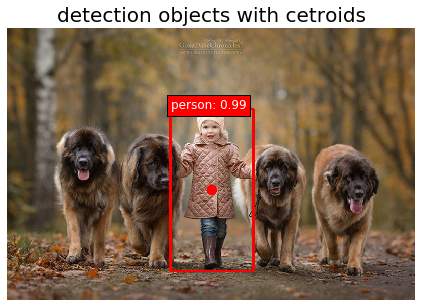

In [5]:
img_path = 'examples/test.jpg'
img = cv2.imread(img_path)
output, cent = SSD_predict(img,0.5,classes,labels=['person'])
SSD_draw(img,output,cent)

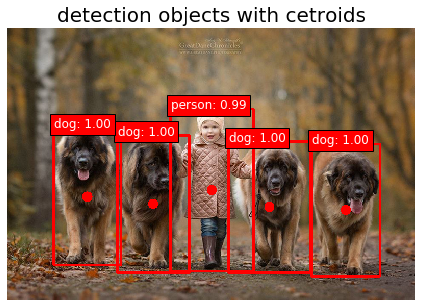

In [6]:
output, cent = SSD_predict(img,0.5,classes,labels=['person','dog'])
SSD_draw(img,output,cent)

## Video input analysis

In [7]:
def video_background(url,alpha):
    '''
    --input--
    url: YouTube URL
    alpha: alpha value for moving average
    --output--
    background image with moving objects filtered out
    '''
    pa = pafy.new(url)
    video = pa.getbest(preftype='webm')
    cap = cv2.VideoCapture(video.url)

    frame_numbers = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    vid_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    FPS = cap.get(cv2.CAP_PROP_FPS)

    _, img = cap.read()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    average_img = np.float32(img) 

    while cap.isOpened():
        ret,img = cap.read() 
        if ret == True:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

            cv2.accumulateWeighted(img, average_img,alpha)   
            background = cv2.convertScaleAbs(average_img) 
        else:
            break
    cap.release()
    print('title: {}'.format(pa.title))
    print('duration: {}'.format(pa.duration))
    print('frame #: {}'.format(frame_numbers))
    print('original FPS: {:.2f}'.format(FPS))
    print('width: {}'.format(vid_width))
    print('height: {}'.format(vid_height))
    
    return background,vid_height,vid_width,FPS

In [8]:
url = 'https://www.youtube.com/watch?v=KMJS66jBtVQ' # original store
# url = 'https://www.youtube.com/watch?v=0yNiX9nt43U' # testing store
background,vid_height,vid_width,FPS = video_background(url,alpha=0.005)

title: HD CCTV Camera video 3MP 4MP iProx CCTV HDCCTVCameras.net retail store
duration: 00:01:51
frame #: 1452
original FPS: 13.09
width: 634
height: 360


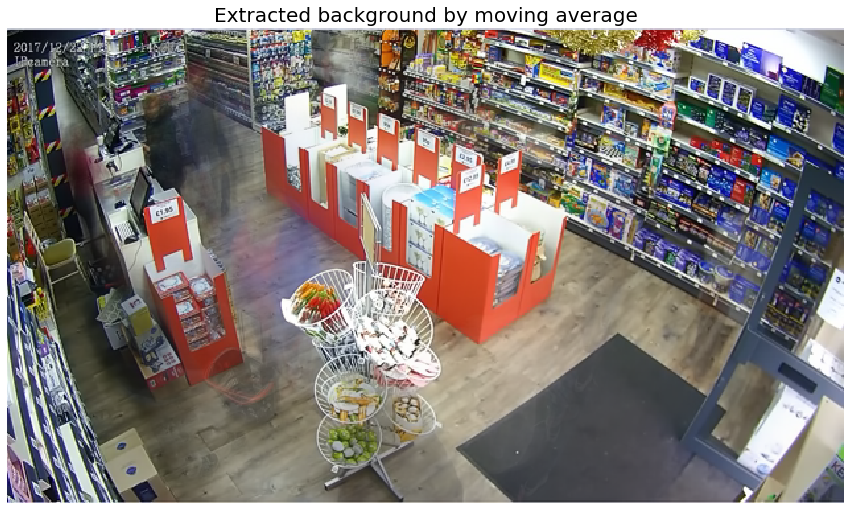

In [9]:
plt.figure(figsize=(15,10))
plt.imshow(background)
plt.title('Extracted background by moving average',fontsize=20)
plt.axis('off')
plt.show()

In [10]:
def select_frame(url,sec):
    '''
    --input--
    url: YouTube URL,
    sec: specific time of the video (in sec),
    --output--
    frame: frame image (BGR)
    '''
    frame_count = 0

    pa = pafy.new(url)
    video = pa.getbest(preftype='webm')
    cap = cv2.VideoCapture(video.url)
    FPS = cap.get(cv2.CAP_PROP_FPS)
    while cap.isOpened():
        ret,frame = cap.read()
        if ret == True:
            if frame_count != np.floor(sec*FPS):
                frame_count += 1
                continue
            else:
                print('time (sec): {:.2f}'.format(sec))
                break
    cap.release()
    
    return frame

time (sec): 0.00


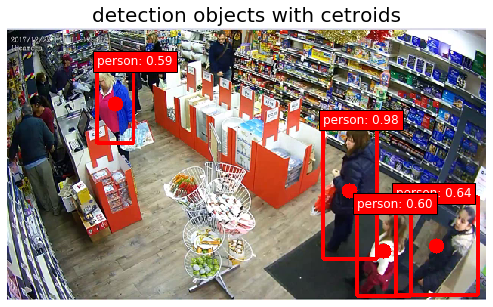

In [11]:
selected_frame = select_frame(url,0)
output, cent = SSD_predict(selected_frame,0.1,classes,labels=['person'])
SSD_draw(selected_frame,output,cent)

time (sec): 80.00


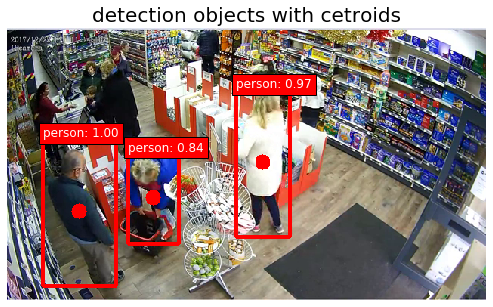

In [12]:
selected_frame = select_frame(url,80)
output, cent = SSD_predict(selected_frame,0.1,classes,labels=['person'])
SSD_draw(selected_frame,output,cent)

In [13]:
def save_frame_range_video(url,saving_video_file_name,FPS,start_sec=0,end_sec=None):
    '''
    --input--
    url: YouTube URL,
    saving_video_file_name: saving file name of the video clip,
    FPS: FPS of the original video,
    start_sec: start time of the video clip (in sec),
    end_sec: end time of the video clip (in sec); if not defined -- end of the video
    --output--
    saved video clip (.avi)
    '''
    print('video starts at {:.2f} sec'.format(start_sec))

    frame_count = 0

    pa = pafy.new(url)
    play = pa.getbest(preftype='webm')
    cap = cv2.VideoCapture(play.url)

    if (cap.isOpened() == False):
        print('cannot read a video')

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(saving_video_file_name+'.avi',fourcc,FPS,(vid_width,vid_height))
    
    if end_sec is None:
        end_sec = pa.length
    
    while (cap.isOpened() and frame_count<np.floor(end_sec*FPS)) :
        _,frame = cap.read()
        if frame_count<np.floor(start_sec*FPS):
            frame_count += 1
            continue    
        out.write(frame)
        frame_count += 1
        
    print('video ends at {:.2f} sec'.format(end_sec))
    print('clipped video saved as: "{}.avi"'.format(saving_video_file_name))
    cap.release()
    out.release() 

In [14]:
color_palatte = {}
def color_by_index(idx):
    if idx not in color_palatte.keys():
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        color_palatte[idx] = (r,g,b)      
    return color_palatte[idx]

color_palatte_norm = {}
def color_by_index_norm(idx):
    r,g,b = color_palatte[idx]
    color_palatte_norm[idx] = (b/255,g/255,r/255)
    return color_palatte_norm[idx]

## CV2 read image in BGR and write image in BGR as well

In [15]:
def motion_tracking(url,video_name,file_name,skip_frame,min_dist_thresh,removing_thresh,confi_thresh,start_sec=0,end_sec=None):
    
    initial_time = dt.datetime.fromtimestamp(tm.time())
    
    background,vid_height,vid_width,FPS = video_background(url,alpha=0.005)  
    height_fix_factor = vid_height/512
    width_fix_factor = vid_width/512
    label_to_track = 'person'

    frame_count = 0

    print('processing starts at {:.2f} sec'.format(start_sec))

    pa = pafy.new(url)
    play = pa.getbest(preftype='webm')
    cap = cv2.VideoCapture(play.url)

    if (cap.isOpened() == False):
        print('cannot read a video')

    track_history = {}
    moving_tracker = {}
    archive = {}
    customer_idx = 1 ## customer id

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_name+'.avi',fourcc,FPS,(vid_width,vid_height))

    if end_sec is None:
        end_sec = pa.length    
    
    while cap.isOpened() and frame_count<np.floor(end_sec*FPS):

        ret,frame = cap.read()
        
        if frame_count<np.floor(start_sec*FPS):
            frame_count += 1
            continue

        if ret == True:

            frame = np.asarray(frame)
            orig_frame = np.copy(frame)
            
            if frame_count% skip_frame == 0:
                frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame,(img_height,img_width))
                frame = np.expand_dims(frame,0)
                current_centroids = [] #reset current centroid list at every processing frame

                ## for the very first frame 
                if not track_history:
                    result = model.predict(frame)
                    results = result[0][result[0,:,1] >= confi_thresh]

                    results = filter_by_classes(results,labels=[label_to_track])

                    for r in results:
                        r[2] = xmin = int(r[2]*width_fix_factor)
                        r[3] = ymin = int(r[3]*height_fix_factor)
                        r[4] = xmax = int(r[4]*width_fix_factor)
                        r[5] = ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
#                         current_centroids.append(centroid)

                        ## add the list of positions
                        track_history[customer_idx] = [initial_time+dt.timedelta(seconds=frame_count/FPS),[centroid]] 
                        moving_tracker[customer_idx] = 0 # initialize moving racker
                        customer_idx += 1
                        
                else:
                    result = model.predict(frame)
                    results = result[0][result[0,:,1] >= confi_thresh]
                    results = filter_by_classes(results,labels=[label_to_track])

                    for r in results:
                        r[2] = xmin = int(r[2]*width_fix_factor)
                        r[3] = ymin = int(r[3]*height_fix_factor)
                        r[4] = xmax = int(r[4]*width_fix_factor)
                        r[5] = ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        current_centroids.append(centroid)
#                     print('for frame {}: {}'.format(frame_count,current_centroids))#######################################

                    track_history_temp = copy.deepcopy(track_history)
                    track_history_key_temp = copy.deepcopy(list(track_history.keys()))

                    ## comparison
                    for cent in current_centroids:
                        min_dist = min_dist_thresh
                        min_label = None
                        for label in track_history_key_temp:
                            dist = distance.euclidean(cent,track_history_temp[label][-1][-1])
                            if dist<min_dist:
                                min_dist = dist
                                min_label = label 

                        ## for same label centroid
                        if min_label is not None:
                            if min_dist == 0: # if object not moved, increase the moving tracker counter by 1
                                moving_tracker[min_label] += 1
                            else: # if moved, reset the tracker counter
                                moving_tracker[min_label] = 0
                            track_history_temp[min_label][-1].append(cent)
                            track_history_key_temp.remove(min_label)

                        #min_label is NONE --> NEW object in the scene
                        else: 
                            track_history_temp[customer_idx] = [initial_time+dt.timedelta(seconds=frame_count/FPS),[cent]]
                            moving_tracker[customer_idx] = 0
                            customer_idx += 1
                    ## object hidden or exit
                    if track_history_key_temp: 
                        for left_over in track_history_key_temp:
                            moving_tracker[left_over] += 1
                            track_history_temp[left_over][-1].append(track_history_temp[left_over][-1][-1])

                    track_history = track_history_temp # update the history
                    
#                     print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
#                     print('moving tracker: {}'.format(moving_tracker))
#                     print('\n')
                    
                ## generate orig_frame based on track_history
                for idx,loc in track_history.items():
                    cv2.circle(orig_frame,loc[-1][-1],10,color_by_index(idx),cv2.FILLED)

                ## move the unmoving objects to the archive dictionary
                moving_tracker_temp = copy.deepcopy(moving_tracker)
                for obj,counter in moving_tracker_temp.items():
                    if counter == removing_thresh:
                        archive[obj] = [track_history[obj][0],track_history[obj][-1][:-removing_thresh]]
                        del track_history[obj]
                        del moving_tracker[obj]
                print('>',end='')
            
            ## in-between frames
            else:
                for idx,loc in track_history.items():
                    cv2.circle(orig_frame,loc[-1][-1],10,color_by_index(idx),cv2.FILLED)

            out.write(orig_frame)
            frame_count += 1

        else:
            break
    print('\n')
    print('proccesing finished at {:.2f} sec'.format(frame_count/FPS))
    print('Total time processed: {:.2f} sec'.format(frame_count/FPS-start_sec))
    cap.release()
    out.release()
    
    ## after all, move all to archive
    moving_tracker_temp = copy.deepcopy(moving_tracker)
    for obj,counter in moving_tracker_temp.items():
        archive[obj] = [track_history[obj][0],track_history[obj][-1]]
        del track_history[obj]
        del moving_tracker[obj]
        
    sorted_archive = sorted(archive.items(),key=lambda kv: kv[1][0],reverse=False)
    sorted_archive = collections.OrderedDict(sorted_archive)
    
    pickle.dump(sorted_archive,open('file_name'+'.pkl','wb'))
        
    print('processed video saved as: "{}.avi"'.format(video_name))
    print('file saved as: "{}.txt"'.format(file_name))
    
    return sorted_archive

In [77]:
## sort by keys
# sorted_archive = {}
# for key in sorted(archive.keys()):
#     sorted_archive[key]=archive[key]

In [16]:
saving_video_file_name = 'large_retail_original_time'
video_name = 'testing'
file_name = 'testing'
start = 0
end = 5

In [17]:
save_frame_range_video(url,saving_video_file_name,FPS,start,end)
print('')
sorted_archive = motion_tracking(url,
                                 video_name=video_name,
                                 file_name=file_name,
                                 skip_frame=10,
                                 min_dist_thresh=35,
                                 removing_thresh=10,
                                 confi_thresh=0.1,
                                 start_sec=start,
                                 end_sec=end)

video starts at 0.00 sec
video ends at 5.00 sec
clipped video saved as: "large_retail_original_time.avi"

title: HD CCTV Camera video 3MP 4MP iProx CCTV HDCCTVCameras.net retail store
duration: 00:01:51
frame #: 1452
original FPS: 13.09
width: 634
height: 360
processing starts at 0.00 sec
>>>>>>>

proccesing finished at 4.96 sec
Total time processed: 4.96 sec
processed video saved as: "testing.avi"
file saved as: "testing.txt"


### Loading the saved file

In [92]:
# sorted_archive = pickle.load(open('file_name'+'.pkl','rb'))

### Time slicing

In [84]:
def time_slice(full_dict,dt_obj=None,flag=None):
    sliced_archive = {}
    if dt_obj is None or flag is None:
        return print('Please define your params!')
    
    if len(dt_obj) == 1:
        if flag == 'after':
            for k,v in sorted_archive.items():
                if v[0] > dt_obj[0]:
                    sliced_archive[k] = sorted_archive[k] 
            return sliced_motion

        if flag == 'before':
            for k,v in sorted_archive.items():
                if v[0] < dt_obj[0]:
                    sliced_archive[k] = sorted_archive[k] 
            return sliced_archive
        else:
            return print('wrong flag!')
        
    if len(dt_obj) == 2:
        if flag == 'in':
            for k,v in sorted_archive.items():
                if v[0] > dt_obj[0] and v[0] < dt_obj[1]:
                    sliced_archive[k] = sorted_archive[k] 
            return sliced_archive

        if flag == 'out':
            for k,v in sorted_archive.items():
                if v[0] < dt_obj[0] or v[0] > dt_obj[1]:
                    sliced_archive[k] = sorted_archive[k] 
            return sliced_archive
        else:
            return print('wrong flag!')
    else:
        return print('the maximum number of dt_obj is two!')

In [85]:
## sample datatime objects
tm_1 = dt.datetime(2019, 9, 24, 9, 53, 44)
tm_2 = dt.datetime(2019, 9, 24, 9, 53, 49)

In [86]:
sliced_archive = time_slice(sorted_archive,dt_obj=[tm_1,tm_2],flag='in')

### Resulting maps

In [78]:
def contour_draw(dict_input,alpha=0.6,n_levels=5,figsize=(20,10)):
    xx = []
    yy = []
    for key in dict_input.keys():
        for centroid in dict_input[key][1]:
            xx.append(centroid[0])
            yy.append(centroid[1])
    fig, ax = plt.subplots(figsize=figsize)
    plt.imshow(background,alpha=alpha)
    sns.kdeplot(xx,yy,ax=ax,n_levels=n_levels) 
    plt.axis('off')
    plt.show()

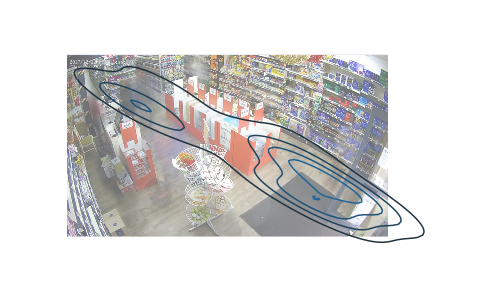

In [80]:
contour_draw(sorted_archive,alpha=0.6,n_levels=5,figsize=(10,5))

In [81]:
def tracjactory_draw(dict_input,alpha=0.3,markersize=20,lw=10,figsize=(15,8)):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.imshow(background,alpha=0.5)
    for key in dict_input.keys():
        x = []
        y = []
        for centroid in dict_input[key][1]:
            x.append(centroid[0])
            y.append(centroid[1])
        ax.plot(x,y,marker='o',c=color_by_index_norm(key),alpha=alpha,markersize=markersize,lw=lw)
    plt.axis('off')
    plt.show()

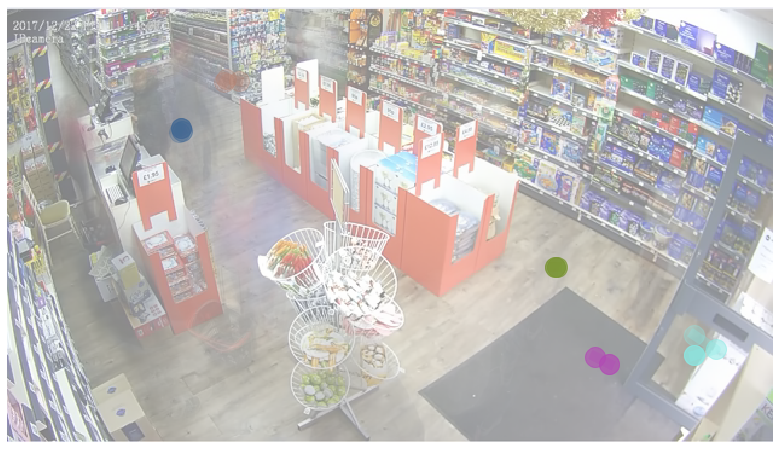

In [87]:
tracjactory_draw(sliced_archive,alpha=0.3,markersize=20,lw=10,figsize=(15,8))

## Todo
* flask implementation

### Centroid tracking algorithm validation

In [93]:
min_dist_thresh = 35
current_centroids = [(455, 215), (191, 61), (142, 103), (486, 289), (586, 283)]
track_history = {1: [(453, 215), (453, 215), (453, 215), (453, 215)], 2: [(568, 288), (568, 288), (568, 288), (568, 288)], 3: [(498, 295), (498, 295), (498, 295), (498, 295)], 4: [(143, 100), (143, 100), (143, 100), (143, 100)]}
moving_tracker = {1: 3, 2: 3, 3: 3, 4: 3}

track_history_temp = copy.deepcopy(track_history)
track_history_key_temp = copy.deepcopy(list(track_history.keys()))

In [94]:
track_history

{1: [(453, 215), (453, 215), (453, 215), (453, 215)],
 2: [(568, 288), (568, 288), (568, 288), (568, 288)],
 3: [(498, 295), (498, 295), (498, 295), (498, 295)],
 4: [(143, 100), (143, 100), (143, 100), (143, 100)]}

In [95]:
track_history_temp

{1: [(453, 215), (453, 215), (453, 215), (453, 215)],
 2: [(568, 288), (568, 288), (568, 288), (568, 288)],
 3: [(498, 295), (498, 295), (498, 295), (498, 295)],
 4: [(143, 100), (143, 100), (143, 100), (143, 100)]}

In [96]:
track_history_key_temp

[1, 2, 3, 4]

In [97]:
idx=5
for cent in current_centroids:
    min_dist = min_dist_thresh
    min_label = None
    for label in track_history_key_temp:
        dist = distance.euclidean(cent,track_history_temp[label][-1])
        if dist<min_dist:
            min_dist = dist
            min_label = label 

    ## for same label centroid
    if min_label is not None:
        if min_dist == 0: # if object not moved, increase the moving tracker counter by 1
            moving_tracker[min_label] += 1
        else: # if moved, reset the tracker counter
            moving_tracker[min_label] = 0
        track_history_temp[min_label].append(cent)
        track_history_key_temp.remove(min_label)

    #min_label is NONE --> NEW object in the scene
    else: 
        track_history_temp[idx] = [cent]
        moving_tracker[idx] = 0
        idx += 1

In [98]:
track_history_temp

{1: [(453, 215), (453, 215), (453, 215), (453, 215), (455, 215)],
 2: [(568, 288), (568, 288), (568, 288), (568, 288), (586, 283)],
 3: [(498, 295), (498, 295), (498, 295), (498, 295), (486, 289)],
 4: [(143, 100), (143, 100), (143, 100), (143, 100), (142, 103)],
 5: [(191, 61)]}

In [99]:
track_history_key_temp

[]

## Archives

In [ ]:
def motion_tracking(url,video_name,file_name,skip_frame,min_dist_thresh,removing_thresh,confi_thresh,start_sec=0,end_sec=None):
    
    initial_time = dt.datetime.fromtimestamp(tm.time())
    
    background,vid_height,vid_width,FPS = video_background(url,alpha=0.005)  
    height_fix_factor = vid_height/512
    width_fix_factor = vid_width/512
    label_to_track = 'person'

    frame_count = 0

    print('processing starts at {:.2f} sec'.format(start_sec))

    pa = pafy.new(url)
    play = pa.getbest(preftype='webm')
    cap = cv2.VideoCapture(play.url)

    if (cap.isOpened() == False):
        print('cannot read a video')

    track_history = {}
    moving_tracker = {}
    archive = {}
    customer_idx = 1 ## customer id

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_name+'.avi',fourcc,FPS,(vid_width,vid_height))

    if end_sec is None:
        end_sec = pa.length    
    
    while cap.isOpened() and frame_count<np.floor(end_sec*FPS):

        ret,frame = cap.read()
        
        if frame_count<np.floor(start_sec*FPS):
            frame_count += 1
            continue

        if ret == True:

            frame = np.asarray(frame)
            orig_frame = np.copy(frame)
            
            if frame_count% skip_frame == 0:
                frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame,(img_height,img_width))
                frame = np.expand_dims(frame,0)
                current_centroids = [] #reset current centroid list at every processing frame

                ## for the very first frame 
                if not track_history:
                    result = model.predict(frame)
                    results = result[0][result[0,:,1] >= confi_thresh]

                    results = filter_by_classes(results,labels=[label_to_track])

                    for r in results:
                        r[2] = xmin = int(r[2]*width_fix_factor)
                        r[3] = ymin = int(r[3]*height_fix_factor)
                        r[4] = xmax = int(r[4]*width_fix_factor)
                        r[5] = ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
#                         current_centroids.append(centroid)

                        ## add the list of positions
                        track_history[customer_idx] = [initial_time+dt.timedelta(seconds=frame_count/FPS),[centroid]] 
                        moving_tracker[customer_idx] = 0 # initialize moving racker
                        customer_idx += 1
                        
                else:
                    result = model.predict(frame)
                    results = result[0][result[0,:,1] >= confi_thresh]
                    results = filter_by_classes(results,labels=[label_to_track])

                    for r in results:
                        r[2] = xmin = int(r[2]*width_fix_factor)
                        r[3] = ymin = int(r[3]*height_fix_factor)
                        r[4] = xmax = int(r[4]*width_fix_factor)
                        r[5] = ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        current_centroids.append(centroid)
#                     print('for frame {}: {}'.format(frame_count,current_centroids))#######################################

                    track_history_temp = copy.deepcopy(track_history)
                    track_history_key_temp = copy.deepcopy(list(track_history.keys()))

                    ## comparison
                    for cent in current_centroids:
                        min_dist = min_dist_thresh
                        min_label = None
                        for label in track_history_key_temp:
                            dist = distance.euclidean(cent,track_history_temp[label][-1][-1])
                            if dist<min_dist:
                                min_dist = dist
                                min_label = label 

                        ## for same label centroid
                        if min_label is not None:
                            if min_dist == 0: # if object not moved, increase the moving tracker counter by 1
                                moving_tracker[min_label] += 1
                            else: # if moved, reset the tracker counter
                                moving_tracker[min_label] = 0
                            track_history_temp[min_label][-1].append(cent)
                            track_history_key_temp.remove(min_label)

                        #min_label is NONE --> NEW object in the scene
                        else: 
                            track_history_temp[customer_idx] = [initial_time+dt.timedelta(seconds=frame_count/FPS),[cent]]
                            moving_tracker[customer_idx] = 0
                            customer_idx += 1
                    ## object hidden or exit
                    if track_history_key_temp: 
                        for left_over in track_history_key_temp:
                            moving_tracker[left_over] += 1
                            track_history_temp[left_over][-1].append(track_history_temp[left_over][-1][-1])

                    track_history = track_history_temp # update the history
                    
#                     print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
#                     print('moving tracker: {}'.format(moving_tracker))
#                     print('\n')
                    
                ## generate orig_frame based on track_history
                for idx,loc in track_history.items():
                    cv2.circle(orig_frame,loc[-1][-1],10,color_by_index(idx),cv2.FILLED)

                ## move the unmoving objects to the archive dictionary
                moving_tracker_temp = copy.deepcopy(moving_tracker)
                for obj,counter in moving_tracker_temp.items():
                    if counter == removing_thresh:
                        archive[obj] = [track_history[obj][0],track_history[obj][-1][:-removing_thresh]]
                        del track_history[obj]
                        del moving_tracker[obj]
                print('>',end='')
            
            ## in-between frames
            else:
                for idx,loc in track_history.items():
                    cv2.circle(orig_frame,loc[-1][-1],10,color_by_index(idx),cv2.FILLED)

            out.write(orig_frame)
            frame_count += 1

        else:
            break
    print('\n')
    print('proccesing finished at {:.2f} sec'.format(frame_count/FPS))
    print('Total time processed: {:.2f} sec'.format(end_sec-start_sec))
    cap.release()
    out.release()
    
    ## after all, move all to archive
    moving_tracker_temp = copy.deepcopy(moving_tracker)
    for obj,counter in moving_tracker_temp.items():
        archive[obj] = [track_history[obj][0],track_history[obj][-1]]
        del track_history[obj]
        del moving_tracker[obj]
        
    sorted_archive = sorted(archive.items(), key=lambda kv: kv[1][0],reverse=False)
    sorted_archive = collections.OrderedDict(sorted_archive)
    
    pickle.dump(sorted_archive,open('file_name'+'.pkl','wb'))
        
    print('processed video saved as: "{}.avi"'.format(video_name))
    print('file saved as: "{}.txt"'.format(file_name))
    
    return sorted_archive

In [82]:
def motion_tracking(url,video_name,file_name,skip_frame,min_dist_thresh,removing_thresh,confi_thresh,start_sec=0,end_sec=None):

    background,vid_height,vid_width,FPS = video_background(url,alpha=0.005)  
    height_fix_factor = vid_height/512
    width_fix_factor = vid_width/512
    label_to_track = 'person'

    frame_count = 0

    print('processing starts at {:.2f} sec'.format(start_sec))

    pa = pafy.new(url)
    play = pa.getbest(preftype='webm')
    cap = cv2.VideoCapture(play.url)

    if (cap.isOpened() == False):
        print('cannot read a video')

    track_history = {}
    moving_tracker = {}
    archive = {}
    customer_idx = 1 ## customer id

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_name+'.avi',fourcc,FPS,(vid_width,vid_height))

    if end_sec is None:
        end_sec = pa.length    
    
    while (cap.isOpened() and frame_count<np.floor(end_sec*FPS)) :

        ret,frame = cap.read()
        if frame_count<np.floor(start_sec*FPS):
            frame_count += 1
            continue

        if ret == True:

            frame = np.asarray(frame)
            orig_frame = np.copy(frame)
            
            if frame_count% skip_frame == 0:
                frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame,(img_height,img_width))
                frame = np.expand_dims(frame,0)
                current_centroids = [] #reset current centroid list at every frame

                ## for the very first frame 
                if not track_history:
                    result = model.predict(frame)
                    results = result[0][result[0,:,1] >= confi_thresh]

                    results = filter_by_classes(results,labels=[label_to_track])

                    for r in results:
                        print('index before: {}'.format(customer_idx))
                        r[2] = xmin = int(r[2]*width_fix_factor)
                        r[3] = ymin = int(r[3]*height_fix_factor)
                        r[4] = xmax = int(r[4]*width_fix_factor)
                        r[5] = ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))

                        track_history[customer_idx] = [centroid] # add the list of positions
                        moving_tracker[customer_idx] = 0 # initialize moving racker
                        customer_idx += 1
                        print('index after: {}'.format(customer_idx))
                else:
                    result = model.predict(frame)
                    results = result[0][result[0,:,1] >= confi_thresh]
                    results = filter_by_classes(results,labels=[label_to_track])

                    for r in results:
                        r[2] = xmin = int(r[2]*width_fix_factor)
                        r[3] = ymin = int(r[3]*height_fix_factor)
                        r[4] = xmax = int(r[4]*width_fix_factor)
                        r[5] = ymax = int(r[5]*height_fix_factor)
                        centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
                        current_centroids.append(centroid)
                    print('for frame {}: {}'.format(frame_count,current_centroids))#######################################
                    print('MY INDEX {}'.format(customer_idx))
#                     current_centroids_temp = copy.deepcopy(current_centroids)
                    track_history_temp = copy.deepcopy(track_history)
                    track_history_key_temp = copy.deepcopy(list(track_history.keys()))

                    ## original stays unchanged
                    for cent in current_centroids:
                        min_dist = min_dist_thresh
                        min_label = None
                        for label in track_history_key_temp:
                            dist = distance.euclidean(cent,track_history_temp[label][-1])
                            if dist<min_dist:
                                min_dist = dist
                                min_label = label 

                        ## for same label centroid
                        if min_label is not None:
                            if min_dist == 0: # if object not moved, increase the moving tracker counter by 1
                                moving_tracker[min_label] += 1
                            else: # if moved, reset the tracker counter
                                moving_tracker[min_label] = 0
                            track_history_temp[min_label].append(cent)
#                             current_centroids_temp.remove(cent)
                            track_history_key_temp.remove(min_label)

                        #min_label is NONE --> NEW object in the scene
                        else: 
                            track_history_temp[customer_idx] = [cent]
                            moving_tracker[customer_idx] = 0
                            customer_idx += 1
                            
                    ## object hidden or exit
                    if track_history_key_temp: 
                        for left_over in track_history_key_temp:
                            moving_tracker[left_over] += 1
                            track_history_temp[left_over].append(track_history_temp[left_over][-1])

                    track_history = track_history_temp # update the history
                    print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
                    print('moving tracker: {}'.format(moving_tracker))
                    print('\n')
                    
                ## generate orig_frame based on track_history
                for idx,loc in track_history.items():
                    cv2.circle(orig_frame,loc[-1],10,color_by_index(idx),cv2.FILLED)

                ## move the unmoving objects to the archive dictionary
                moving_tracker_temp = copy.deepcopy(moving_tracker)
                for obj,counter in moving_tracker_temp.items():
                    if counter == removing_thresh:
                        archive[obj] = track_history[obj][:-removing_thresh]
                        del track_history[obj]
                        del moving_tracker[obj]
                print('>',end='')
            
            ## in-between frames
            else:
                for idx,loc in track_history.items():
                    cv2.circle(orig_frame,loc[-1],10,color_by_index(idx),cv2.FILLED)

            out.write(orig_frame)
            frame_count += 1

        else:
            break
    print('\n')
    print('proccesing finished at {:.2f} sec'.format(frame_count/FPS))
    print('Total time processed: {:.2f} sec'.format(end_sec-start_sec))
    cap.release()
    out.release()
    
    ## after all, move all to archive
    moving_tracker_temp = copy.deepcopy(moving_tracker)
    for obj,counter in moving_tracker_temp.items():
        archive[obj] = track_history[obj]
        del track_history[obj]
        del moving_tracker[obj]

    sorted_archive = {}
    for key in sorted(archive.keys()):
        sorted_archive[key]=archive[key]
    json.dump(sorted_archive, open('file_name'+'.txt','w'))
    
    print('processed video saved as: "{}.avi"'.format(video_name))
    print('file saved as: "{}.txt"'.format(file_name))
    
    return sorted_archive

In [ ]:
print('processing ongoing',end='')
width_fix_factor = vid_width/img_width
height_fix_factor = vid_height/img_height
frame_count = 0
skip_frame = 10
min_dist_thresh = 50
removing_thresh = 10
confi_thresh = 0.25

pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

if (cap.isOpened() == False):
    print('cannot read a video')
    
track_history = {}
moving_tracker = {}
archive = {}
idx = 1 ## customer id

while cap.isOpened():
    ret,frame = cap.read()
    if ret == True:
        frame = np.asarray(frame)
        frame = cv2.resize(frame,(img_height,img_width))
        frame = np.expand_dims(frame,0)
        
        if frame_count % skip_frame == 0:
            current_centroids = [] #reset current centroid list at every frame
            
            ## for the very first frame 
            if not track_history:
                result = model.predict(frame)
                results = result[0][result[0,:,1] >= confi_thresh]
                
                results = filter_by_classes(results,labels=['person'])
        
                for r in results:
                    r[2] = xmin = int(r[2] * width_fix_factor)
                    r[3] = ymin = int(r[3] * height_fix_factor)
                    r[4] = xmax = int(r[4] * width_fix_factor)
                    r[5] = ymax = int(r[5] * height_fix_factor)
                    centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
#                         cv2.rectangle(orig_frame,(xmin,ymin),(xmax,ymax),(0,0,255),thickness=3)
                    track_history[idx] = [centroid] # add the list of positions
                    moving_tracker[idx] = 0 ## initialize moving racker
                    idx += 1

            ## after persons are detected and track_history is created
            else:
                result = model.predict(frame)
                results = result[0][result[0,:,1] >= confi_thresh]
                
                results = filter_by_classes(results,labels=['person'])

                for r in results:
                    r[2] = xmin = int(r[2] * width_fix_factor)
                    r[3] = ymin = int(r[3] * height_fix_factor)
                    r[4] = xmax = int(r[4] * width_fix_factor)
                    r[5] = ymax = int(r[5] * height_fix_factor)
                    centroid = (int(np.mean((xmin,xmax))),int(np.mean((ymin,ymax))))
#                         cv2.rectangle(orig_frame,(xmin,ymin),(xmax,ymax),(0,0,255),thickness=3)
                    current_centroids.append(centroid)
#                 print('for frame {}: {}'.format(frame_count,current_centroids))#######################################

                ## compare and update
                current_centroids_temp = copy.deepcopy(current_centroids)
                track_history_temp = copy.deepcopy(track_history)
                track_history_key_temp = copy.deepcopy(list(track_history.keys()))
                                    
                ## original stays unchanged
                for cent in current_centroids:
                    min_dist = min_dist_thresh # reset min_ variables for each current centroid
                    min_label = None
                    for label in track_history_key_temp:
                        dist = distance.euclidean(cent,track_history_temp[label][-1])
                        if dist<min_dist:
                            min_dist = dist
                            min_label = label 
                            
                    # for same label centroid
                    if min_label is not None:
                        if min_dist == 0: ##if object not moved, increase the moving tracker counter by 1
                            moving_tracker[min_label] += 1
                        else: ## if moved, reset the tracker counter
                            moving_tracker[min_label] = 0
                        ## if moved
                        track_history_temp[min_label].append(cent) ## update the history_temp by appending
                        current_centroids_temp.remove(cent)
                        track_history_key_temp.remove(min_label)
                               
                    #min_label is NONE --> NEW VALUE
                    else: 
                        track_history_temp[idx] = [cent]
                        moving_tracker[idx] = 0
#                         current_centroids_temp.remove(cent)
                        idx += 1
                ## object hidden or exit
                if track_history_key_temp: 
                    for left_over in track_history_key_temp:
                        moving_tracker[left_over] += 1
                        track_history_temp[left_over].append(track_history_temp[left_over][-1])

                track_history = track_history_temp # update the history

#                 print('for frame {} dict: {}'.format(frame_count,track_history))#######################################
#                 print('moving tracker: {}'.format(moving_tracker))
#                 print('\n')
          
            ## move the unmoving objects to the archive dictionary
            moving_tracker_temp = copy.deepcopy(moving_tracker)
            for obj,counter in moving_tracker_temp.items():
                if counter == removing_thresh:
                    archive[obj] = track_history[obj][:-removing_thresh]
                    del track_history[obj]
                    del moving_tracker[obj]

#             print('archieve: {}'.format(archive))
            print('.',end='')
#         cv2.imshow('frame',frame)
        frame_count += 1
        if cv2.waitKey(1) & 0xff == ord('q'):
            break  
    else:
        break
# cv2.destroyAllWindows()
cap.release()
# out.release() 

#after all, move all to archive
moving_tracker_temp = copy.deepcopy(moving_tracker)
for obj,counter in moving_tracker_temp.items():
    archive[obj] = track_history[obj]
    del track_history[obj]
    del moving_tracker[obj]
    
sorted_archive = {}
for key in sorted(archive.keys()):
    sorted_archive[key]=archive[key]
json.dump(sorted_archive, open("motion_history.txt",'w'))